# Model comparison

In model comparison, our goal is to determine which model, out of a set of possible models, is most likely to have generated the data. There are a number of different ways to make this comparison which are briefly summarized in the Appendix of (Wilson and Collins, 2019). Here we focus on the most common method which is related to the log-likelihood.

A simplistic approach to model comparison would be to compare the log-likelihoods of each model at the best fitting parameter settings, $p(d_{1:T} | \hat{\theta}_m, m)$.  However, if the data, $d_{1:T}$, used to evaluate the log-likelihood are the same data used to fit the parameters, then this approach will lead to overfitting, as the model with most free parameters will almost always fit this 'training' data best.  As an extreme example, consider the case of a model with one 'parameter' per choice which is the identity of the choice the person actually made.  Such a 'model' would fit the data perfectly, but would of course tell us nothing about how the choices were actually determined and make no predictions about what choices would be made in a different setting. Overfitting is a problem in that it decreases the generalizability of the model. 

One way to avoid overfitting is to perform cross-validation: by measuring fit on held-out data, we directly test generalizability. However, this is not always possible for practical reasons (number of samples) or more fundamental ones (dependence between data points). Thus, other methods mitigate the risk of overfitting by approximately accounting for the degrees of freedom in the model. Here we focus on one of the simplest methods, the Bayes Information Criterion, $BIC$, which has an explicit penalty for free parameters.  
\begin{equation}
\label{eq:BIC}
    BIC = -2 \log \hat{LL} + k_m \log(T)
\end{equation}
where $\hat{LL}$ is the log-likelihood value at the best fitting parameter settings, and $k_m$ is the number of parameters in model $m$.  The model with the smallest $BIC$ score is the model that best fits the data.  Thus, the positive effect of $k_m$ in the last term corresponds to a penalty for models with large numbers of parameters. 


In [1]:
%%file fit_all_v1.m

% make a function to fit all models to a set of data

function [BIC, iBEST, BEST] = fit_all_v1(a, r)

[~, ~, BIC(1)] = fit_M1random_v1(a, r);
[~, ~, BIC(2)] = fit_M2WSLS_v1(a, r);
[~, ~, BIC(3)] = fit_M3RescorlaWagner_v1(a, r);
[~, ~, BIC(4)] = fit_M4CK_v1(a, r);
[~, ~, BIC(5)] = fit_M5RWCK_v1(a, r);

[M, iBEST] = min(BIC);
BEST = BIC == M;
BEST = BEST / sum(BEST);

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/fit_all_v1.m'.


In [6]:
% generate some data from Model 3 and fit it with all models
T = 50;
mu = [0.2 0.8];
alpha = 0.1;
beta = 5;
[a, r] = simulate_M3RescorlaWagner_v1(50, mu, alpha, beta);

[BIC, iBEST, BEST] = fit_all_v1(a, r)


BIC =

   61.2177   59.8510   41.7804   47.0963   46.4809


iBEST =

     3


BEST =

     0     0     1     0     0



Is this good? Let's repeat the process multiple times and count how many times the data are best fit with model 3 ...

In [11]:
% simulate and fit multiple times with random parameter settings each time

T = 50;
mu = [0.2 0.8];
N_repeats = 10;
% note this may take a minute or so to run if N_repeats is high

COUNT = zeros(1,5);

for n = 1:N_repeats
    alpha = rand;
    beta = 1+exprnd(1);
    
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);

    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    COUNT = COUNT + BEST;
end
COUNT


COUNT =

     6     1     3     0     0



In [13]:
% can improve performance by designing a better experiment - in this case just adding more trials

T = 1000;
mu = [0.2 0.8];
N_repeats = 10;
% note this may take a minute or so to run if N_repeats is high

COUNT = zeros(1,5);

for n = 1:N_repeats
    alpha = rand;
    beta = 1+exprnd(1);
    
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);

    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    COUNT = COUNT + BEST;
end
COUNT


COUNT =

     0     0    10     0     0



## Making a confusion matrix to validate model comparison
Just as parameter fitting should be validated by parameter recovery on simulated data, so should model comparison be validated by model recovery on simulated data. More specifically, this process involves simulating data from all models (with a range of parameter values as in the case of parameter recovery) and then fitting that data with all models to determine the extent to which fake data generated from model $A$ is best fit by model $A$ as opposed to model $B$.  This process can be summarized in a confusion matrix that quantifies the probability that each model is the best fit to data generated from the other models.  In a perfect world the confusion matrix will be the identity matrix, but in practice this is not always the case e.g. (Wilson & Niv, 2012).

In [19]:
% generate a confusion matrix for this task
% this can take a while, start with N_repeats small!


CM = zeros(5);

T = 50;
mu = [0.2 0.8];

N_repeats = 10;


for count = 1:N_repeats
    
    % Model 1
    b = rand;
    [a, r] = simulate_M1random_v1(T, mu, b);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(1,:) = CM(1,:) + BEST;
    
    % Model 2
    epsilon = rand;
    [a, r] = simulate_M2WSLS_v1(T, mu, epsilon);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(2,:) = CM(2,:) + BEST;
    
    % Model 3
    alpha = rand;
    beta = 1+exprnd(1);
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(3,:) = CM(3,:) + BEST;
    
    % Model 4
    alpha_c = rand;
    beta_c = 1+exprnd(1);
    [a, r] = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(4,:) = CM(4,:) + BEST;
    
    % Model 5
    alpha = rand;
    beta = 1+exprnd(1);
    alpha_c = rand;
    beta_c = 1+exprnd(1);
    [a, r] = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(5,:) = CM(5,:) + BEST;
    
end

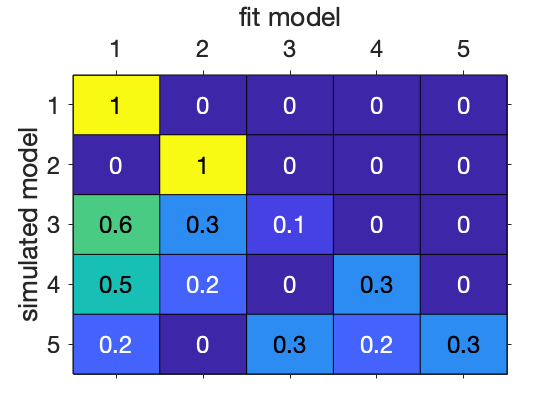

In [22]:
% plot the confusion matrix
figure(1); clf;
FM = round(100*CM/sum(CM(1,:)))/100;
t = imageTextMatrix(FM);
set(t(FM'<0.3), 'color', 'w')
hold on;
[l1, l2] = addFacetLines(CM);
set(t, 'fontsize', 18)
set(gca, 'xtick', [1:5], 'ytick', [1:5], 'fontsize', 18, ...
    'xaxislocation', 'top', 'tickdir', 'out')
xlabel('fit model')
ylabel('simulated model')
    

How does the confusion matrix change as you increase the number of trials in the simulation?

How does the confusion matrix change as you change the sampling distributions for the random parameter values?